In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Using geospatial data to generate a "land vs water" classification task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import manify
import manify.utils

from mpl_toolkits.basemap import Basemap

# Generate a dataset of (longitude, latitude, land/water) tuples
# 1. Generate a grid of points
_x = np.linspace(-180, 180, 100)
_y = np.linspace(-90, 90, 100)
xx, yy = np.meshgrid(_x, _y)
xx = xx.flatten()
yy = yy.flatten()

# 2. Convert to projection coordinates
m = Basemap()
mxx, myy = m(xx, yy)

# 3. Classify each point as land or water
land = np.array([m.is_land(x, y) for x, y in zip(xx, yy)])

# 4. Plot
plt.figure(figsize=(10, 10))
m.drawcoastlines()
m.scatter(xx[land], yy[land], c="blue", s=1)

KeyboardInterrupt: 

In [ ]:
# Generate a dataset

# 1. Convert grid to radians
xx = np.radians(xx)
yy = np.radians(yy)

# 2. Convert radians to 3D coordinates
x = np.cos(yy) * np.cos(xx)
y = np.cos(yy) * np.sin(xx)
z = np.sin(yy)
X = np.stack([x, y, z], axis=1)

# 3. Convert land labels to 0/1
y = land.astype(float)

In [ ]:
# Benchmark
N_TRIALS = 100
N_SAMPLES = 1_000
MAX_DEPTH = 3
N_FEATURES = "d_choose_2"

pm = manify.ProductManifold([(1, 2)])

results = []
for trial in range(N_TRIALS):
    idx = np.random.choice(len(X), N_SAMPLES, replace=False)
    res = manify.utils.benchmarks.benchmark(
        X[idx],
        y[idx],
        pm=pm,
        task="classification",
        seed=trial,
        max_depth=MAX_DEPTH,
        n_features=N_FEATURES,
        models=["product_rf"],
    )
    res["trial"] = trial
    results.append(res)

results = pd.DataFrame(results)

KeyboardInterrupt: 

In [ ]:
results.mean()

In [ ]:
# results.to_csv("../data/results/land_vs_water.tsv", index=False, sep="\t")

# Run this part!

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Visualization
# Using geospatial data to generate a "land vs water" classification task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import manify
import manify.utils

from mpl_toolkits.basemap import Basemap
import torch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

N_POINTS = 200

pm = manify.ProductManifold([(1, 2)])

# 1. Get your inputs, again
_x = np.linspace(-180, 180, N_POINTS)
_y = np.linspace(-90, 90, N_POINTS)
xx, yy = np.meshgrid(_x, _y)
xx = xx.flatten()
yy = yy.flatten()

# 2. Convert to projection coordinates
m = Basemap()
mxx, myy = m(xx, yy)

# 3. Convert grid to radians
xx_rads = np.radians(xx).flatten()
yy_rads = np.radians(yy).flatten()
X = np.stack(
    [
        np.cos(yy_rads) * np.cos(xx_rads),
        np.cos(yy_rads) * np.sin(xx_rads),
        np.sin(yy_rads),
    ],
    axis=1,
)

# 4. Get y vals
y = np.array([m.is_land(x, y) for x, y in zip(mxx, myy)]).astype(float)

In [35]:
MAX_DEPTH = 5
N_FEATURES = "d_choose_2"
SEED = 1
SUBSAMPLE = 200

# 0. Set seeds
np.random.seed(SEED)
torch.manual_seed(SEED)

# 5. Train-test split
idx = np.random.choice(len(X), SUBSAMPLE, replace=False)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X[idx], y[idx], idx, test_size=0.2)

# 6. Predict
# pdt = embedders.tree_new.ProductSpaceDT(pm=pm, max_depth=MAX_DEPTH, task="classification", n_features=N_FEATURES)
pdt = manify.ProductSpaceRF(pm=pm, max_depth=MAX_DEPTH, task="classification", n_features=N_FEATURES, n_estimators=12)
pdt.fit(X_train, y_train)
pdt_score = (pdt.predict(X_test).numpy() == y_test).astype(float).mean()
print(f"pdt_score:\t{pdt_score:.4f}")

# dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=12)
dt.fit(X_train, y_train)
dt_score = (dt.predict(X_test) == y_test).astype(float).mean()
print(f"dt_score:\t{dt_score:.4f}")

X_log_train = pm.logmap(torch.tensor(X_train)).detach().numpy()
X_log_test = pm.logmap(torch.tensor(X_test)).detach().numpy()
tdt = RandomForestClassifier(max_depth=MAX_DEPTH)
tdt.fit(X_log_train, y_train)
tdt_score = (tdt.predict(X_log_test) == y_test).astype(float).mean()
print(f"tdt_score:\t{tdt_score:.4f}")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_score = (knn.predict(X_test) == y_test).astype(float).mean()
print(f"kNeighbors:\t{knn_score:.4f}")

# Get stereographic manifold
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
pm_stereo, X_train_stereo, X_test_stereo = pm.stereographic(X_train, X_test)
pm_ambient = manify.ProductManifold([(0, 3)], stereographic=True)

mlp = manify.KappaGCN(pm=pm_ambient, output_dim=2, task="classification", num_hidden=2)
mlp.fit(X_train, y_train, A=None, epochs=4_000, lr=0.01)
mlp_score = (mlp.predict(X_test).numpy() == y_test.numpy()).astype(float).mean()
print(f"mlp_score:\t{mlp_score:.4f}")

kgcn = manify.KappaGCN(pm=pm_stereo, output_dim=2, task="classification", num_hidden=2)
A_train = manify.predictors.kappa_gcn.get_A_hat(torch.exp(-pm_stereo.pdist(X_train_stereo)))
A_test = manify.predictors.kappa_gcn.get_A_hat(torch.exp(-pm_stereo.pdist(X_test_stereo)))
kgcn.fit(X_train_stereo, y_train, A=A_train, epochs=4_000, lr=0.01)
kgcn_score = (kgcn.predict(X_test_stereo, A=A_test).numpy() == y_test.numpy()).astype(float).mean()
print(f"kgcn_score:\t{kgcn_score:.4f}")

pdt_score:	0.9000
dt_score:	0.8750
tdt_score:	0.8750
kNeighbors:	0.8500


  0%|          | 0/4000 [00:00<?, ?it/s]

mlp_score:	0.8500


  0%|          | 0/4000 [00:00<?, ?it/s]

kgcn_score:	0.8000


In [36]:
# Get predictions

y_pred_pdt = []
for x in tqdm(range(0, len(X), 1000)):
    y_pred_pdt.append(pdt.predict_proba(X[x : x + 1000]).numpy())
y_pred_pdt = np.concatenate(y_pred_pdt)
pdt_score_final = (y_pred_pdt.argmax(axis=1) == y).astype(float).mean()

y_pred_dt = dt.predict_proba(X)
dt_score_final = (y_pred_dt.argmax(axis=1) == y).astype(float).mean()

y_pred_tdt = tdt.predict_proba(pm.logmap(torch.tensor(X)).detach().numpy())
tdt_score_final = (y_pred_tdt.argmax(axis=1) == y).astype(float).mean()

y_pred_knn = knn.predict_proba(X)
knn_score_final = (y_pred_knn.argmax(axis=1) == y).astype(float).mean()

_, X_stereo = pm.stereographic(torch.tensor(X, dtype=torch.float32))
# A = manify.predictors.kappa_gcn.get_A_hat(torch.exp(-pm_stereo.pdist(X_stereo)))

y_pred_mlp = torch.sigmoid(mlp.predict_proba(torch.tensor(X, dtype=torch.float32))).detach().numpy()
mlp_score_final = (y_pred_mlp.argmax(axis=1) == y).astype(float).mean()

y_pred_kgcn = torch.sigmoid(kgcn.predict_proba(X_stereo)).detach().numpy()
kgcn_score_final = (y_pred_kgcn.argmax(axis=1) == y).astype(float).mean()

  0%|          | 0/40 [00:00<?, ?it/s]

<>:89: SyntaxWarning: invalid escape sequence '\k'
<>:119: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\k'
<>:119: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_17209/4262383839.py:89: SyntaxWarning: invalid escape sequence '\k'
  axs[1, 2].set_title(f"$\kappa$-GCN ({kgcn_score_final:.2f})", color="C5", fontweight="bold")
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_17209/4262383839.py:119: SyntaxWarning: invalid escape sequence '\m'
  label="$\mathbb{P}$(Land)",
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_17209/4262383839.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


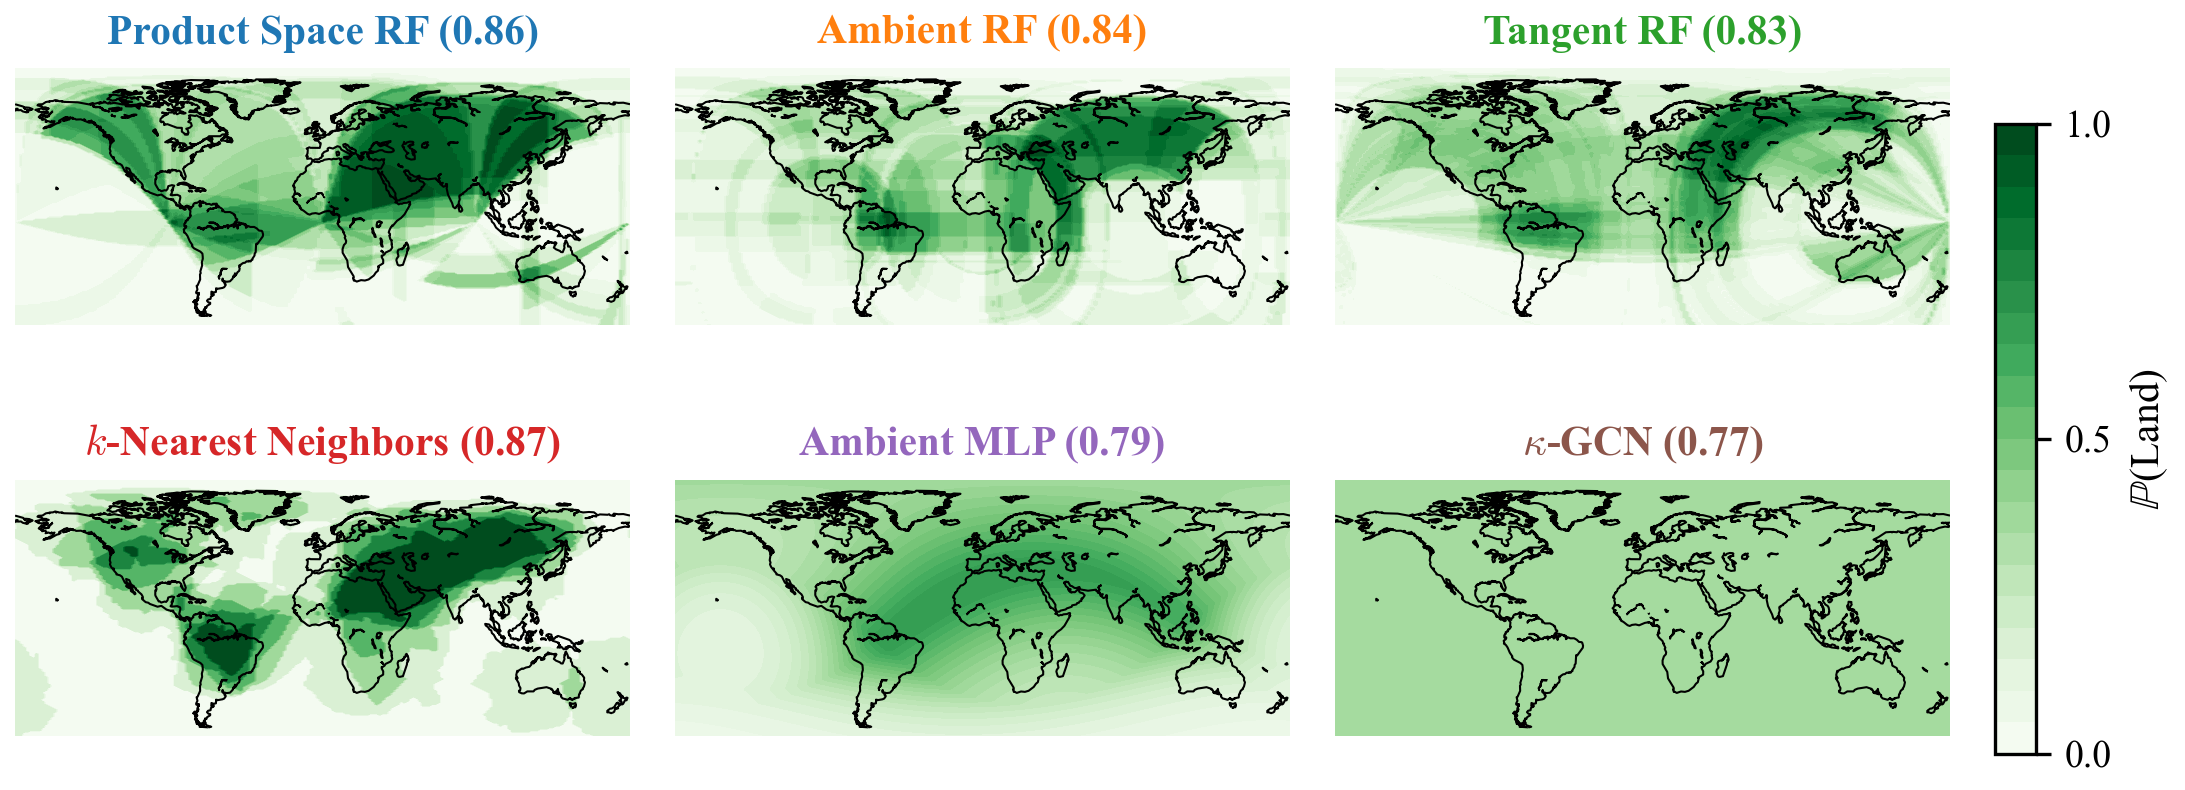

In [37]:
# 7. Plot
import matplotlib as mpl

PROJ = "cyl"  # Projection type
CMAP_MAP = "Greens"
ALPHA = 1
LEVELS = 20

# Load matplotlib rc parameters from icml.mplstyle
plt.style.use("./icml.mplstyle")

# # Set font to LaTeX times font
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
# plt.rcParams["mathtext.fontset"] = "cm"

# FONTSIZE = 10
# LW = 2
# ALPHA = 1
# LEVELS = 20
# POINTSIZE = 4
# # CMAP_MAP = "YlGnBu_r"
# CMAP_MAP = "viridis"
# CMAP_POINTS = mpl.colors.ListedColormap(["red", "limegreen"])
# # PROJ = "robin"
# PROJ = "cyl"
# # PROJ = "moll"
# # PROJ = "winkel3"


fig, axs = plt.subplots(2, 3, figsize=(6.75, 3), dpi=300)

m2 = Basemap(projection=PROJ, lon_0=0, lat_0=0, resolution="c")
test_x_vals, test_y_vals = m2(xx[idx_test], yy[idx_test])
mxx2, myy2 = m2(xx, yy)

contourf_args = [mxx2.reshape(N_POINTS, N_POINTS), myy2.reshape(N_POINTS, N_POINTS)]
contourf_kwargs = {
    "cmap": CMAP_MAP,
    "alpha": ALPHA,
    "levels": LEVELS,
    "vmin": 0,
    "vmax": 1,
}

axs[0, 0].contourf(
    *contourf_args,
    y_pred_pdt[:, 1].reshape(N_POINTS, N_POINTS),
    **contourf_kwargs,
)
axs[0, 0].set_title(f"Product Space RF ({pdt_score_final:.2f})", color="C0", fontweight="bold")

axs[0, 1].contourf(
    *contourf_args,
    y_pred_dt[:, 1].reshape(N_POINTS, N_POINTS),
    **contourf_kwargs,
)
axs[0, 1].set_title(f"Ambient RF ({dt_score_final:.2f})", color="C1", fontweight="bold")
# axs[0, 1].scatter(test_x_vals, test_y_vals, c=(y_pred_dt[idx_test].argmax(axis=1) == y[idx_test]), s=POINTSIZE, cmap=CMAP_POINTS)

axs[0, 2].contourf(
    *contourf_args,
    y_pred_tdt[:, 1].reshape(N_POINTS, N_POINTS),
    **contourf_kwargs,
)
axs[0, 2].set_title(f"Tangent RF ({tdt_score_final:.2f})", color="C2", fontweight="bold")
# axs[1, 0].scatter(test_x_vals, test_y_vals, c=(y_pred_tdt[idx_test].argmax(axis=1) == y[idx_test]), s=POINTSIZE, cmap=CMAP_POINTS)

axs[1, 0].contourf(
    *contourf_args,
    y_pred_knn[:, 1].reshape(N_POINTS, N_POINTS),
    **contourf_kwargs,
)
axs[1, 0].set_title(f"$k$-Nearest Neighbors ({knn_score_final:.2f})", color="C3", fontweight="bold")
# axs[1, 1].scatter(test_x_vals, test_y_vals, c=(y_pred_knn[idx_test].argmax(axis=1) == y[idx_test]), s=POINTSIZE, cmap=CMAP_POINTS)

axs[1, 1].contourf(
    *contourf_args,
    y_pred_mlp[:, 1].reshape(N_POINTS, N_POINTS),
    **contourf_kwargs,
)
axs[1, 1].set_title(f"Ambient MLP ({mlp_score_final:.2f})", color="C4", fontweight="bold")

axs[1, 2].contourf(
    *contourf_args,
    y_pred_kgcn[:, 1].reshape(N_POINTS, N_POINTS),
    **contourf_kwargs,
)
axs[1, 2].set_title(f"$\kappa$-GCN ({kgcn_score_final:.2f})", color="C5", fontweight="bold")


# Cleanup
for ax in axs.flatten():
    m2.drawcoastlines(ax=ax, linewidth=0.5)
    # Ticks off
    ax.set_xticks([])
    ax.set_yticks([])

    # # Rasterize contour plots
    # for coll in ax.collections:
    #     coll.set_rasterized(True)

    # Crop Antarctica
    # print(ax.get_ylim())
    ax.set_ylim(-60, 90)

    # Spines off
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

# Colorbar
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.7])
# Colorbar with font size 20
fig.colorbar(
    axs[1, 0].collections[0],
    cax=cbar_ax,
    orientation="vertical",
    label="$\mathbb{P}$(Land)",
    ticks=[0, 0.5, 1],
)

# plt.suptitle("Decision boundaries visualized: land vs water", position=(0.5, 0.95))
plt.tight_layout()

# Save
# plt.savefig("../figures/land_vs_water.pdf", bbox_inches="tight", dpi=300)